Import all modules 

In [1]:
from db_utils import RDSDatabaseConnector, load_data_from_csv
from DataFormat import DataFormat
from DataFrameInfo import DataFrameInfo
from DataTransform import DataFrameTransform
from Plotter import Plotter
import statsmodels.formula.api as sms


Load data and determine data types and null percentages

In [2]:
#Load Data
df = load_data_from_csv('C:\\Users\\Gurpr\\OneDrive\\Documents\\AI Core\\Exploratory Data Analysis - Customer Loans in Finance\\Data\\output_loan_data.csv')

#Information about dataset
DF_Info = DataFrameInfo(df)

print(DF_Info.get_shape())
print(DF_Info.df.dtypes)


Dataframe Shape:
(54231, 43)
id                               int64
member_id                        int64
loan_amount                      int64
funded_amount                  float64
funded_amount_inv              float64
term                            object
int_rate                       float64
instalment                     float64
grade                           object
sub_grade                       object
employment_length               object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_date                      object
loan_status                     object
payment_plan                    object
purpose                         object
dti                            float64
delinq_2yrs                      int64
earliest_credit_line            object
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_accounts                    in

                                % Null
funded_amount                 5.544799
term                          8.799395
int_rate                      9.531449
employment_length             3.905515
mths_since_last_delinq       57.166565
mths_since_last_record       88.602460
last_payment_date             0.134609
next_payment_date            60.127971
last_credit_pull_date         0.012908
collections_12_mths_ex_med    0.094042
mths_since_last_major_derog  86.172116


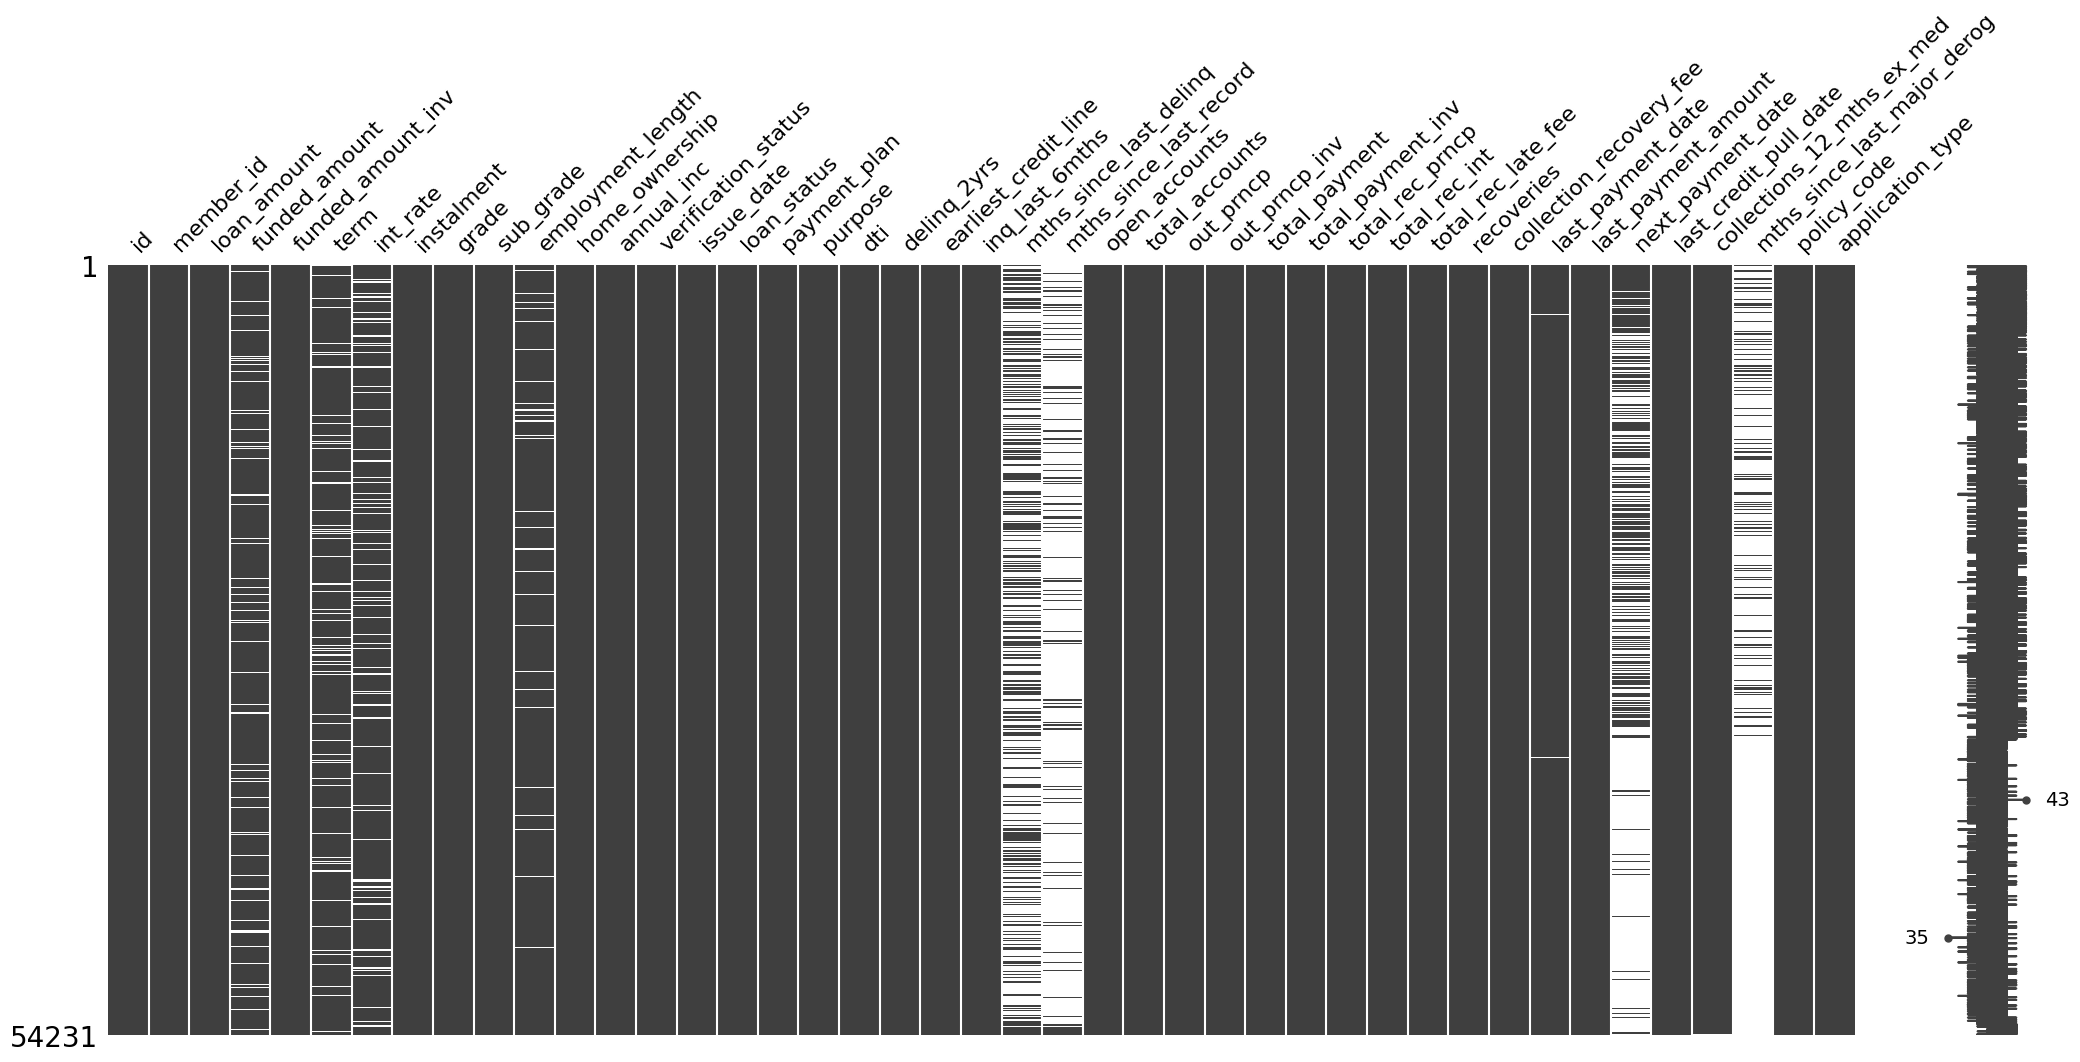

In [3]:
#Information about Null percentages
print(DF_Info.null_percentage())

plt = Plotter(df)
plt.missing_nulls_plot()


Converting columns to a more appropriate format and dropping columns

In [4]:
#Create an instance of the DataFormat Class
DF_Format = DataFormat(df)

#After looking at the data, some column types can be changed. Payment plan can be chnaged to a boolean type
DF_Format.string_to_boolean('payment_plan')

#These are simply dates in string format, converting them to datetime alows for easier analysis 
string_dates = ['issue_date', 'earliest_credit_line', 'last_credit_pull_date', 'last_payment_date']

#These columns columns all have a limited range of data so they can be converted into categpries
categories = ['grade', 'sub_grade', 'home_ownership',
                  'verification_status', 'loan_status', 'purpose']

DF_Format.strings_to_dates(string_dates)
DF_Format.values_to_categories(categories)

#Dropping columns with a high Null percentage:

drop_cols = ['policy_code', 'out_prncp_inv','mths_since_last_record','mths_since_last_delinq','mths_since_last_major_derog'],'next_payment_date'
DF_Format.drop_columns(drop_cols)

#Change values in next payment date

[ True]


Imputing Data

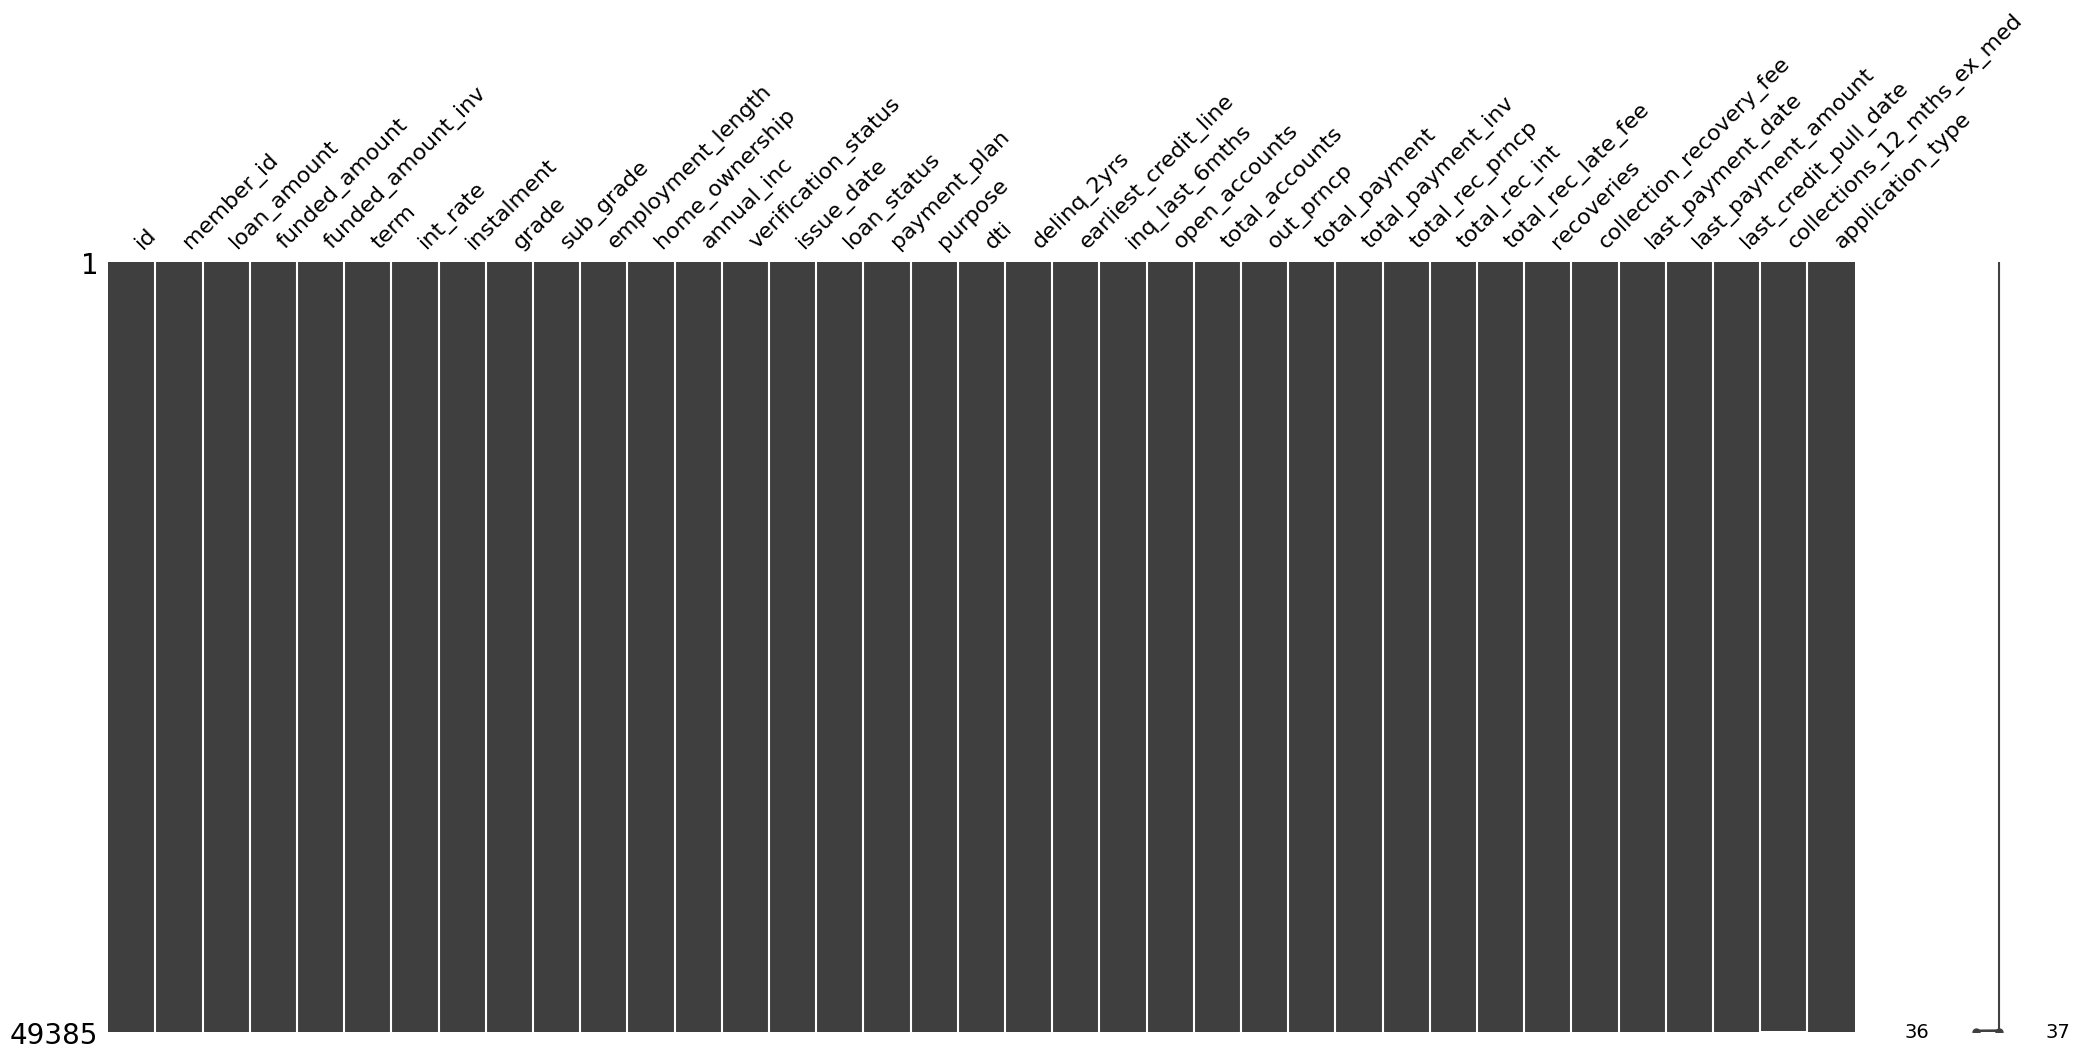

In [5]:
#Impute 

Transform_Formatted_data = DataFrameTransform(DF_Format.df)

#If Loan_status is repaid then there will be no next payment date, hence the null values


# Assume when Employment length is missing it means they don't have a job
#Transform_Formatted_data.impute_empty_with_nan()
Transform_Formatted_data.impute_with_zero(['employment_length'])
# mean interest rate since its within normal dist
Transform_Formatted_data.impute_with_median(['int_rate', 'funded_amount'])

# these rows have insignificant null vals
Transform_Formatted_data.drop_null_rows(['term','last_payment_date', 'last_credit_pull_date'])

#Saving the formatted data

plt1 = Plotter(Transform_Formatted_data.df)
plt1.missing_nulls_plot()


Skewness

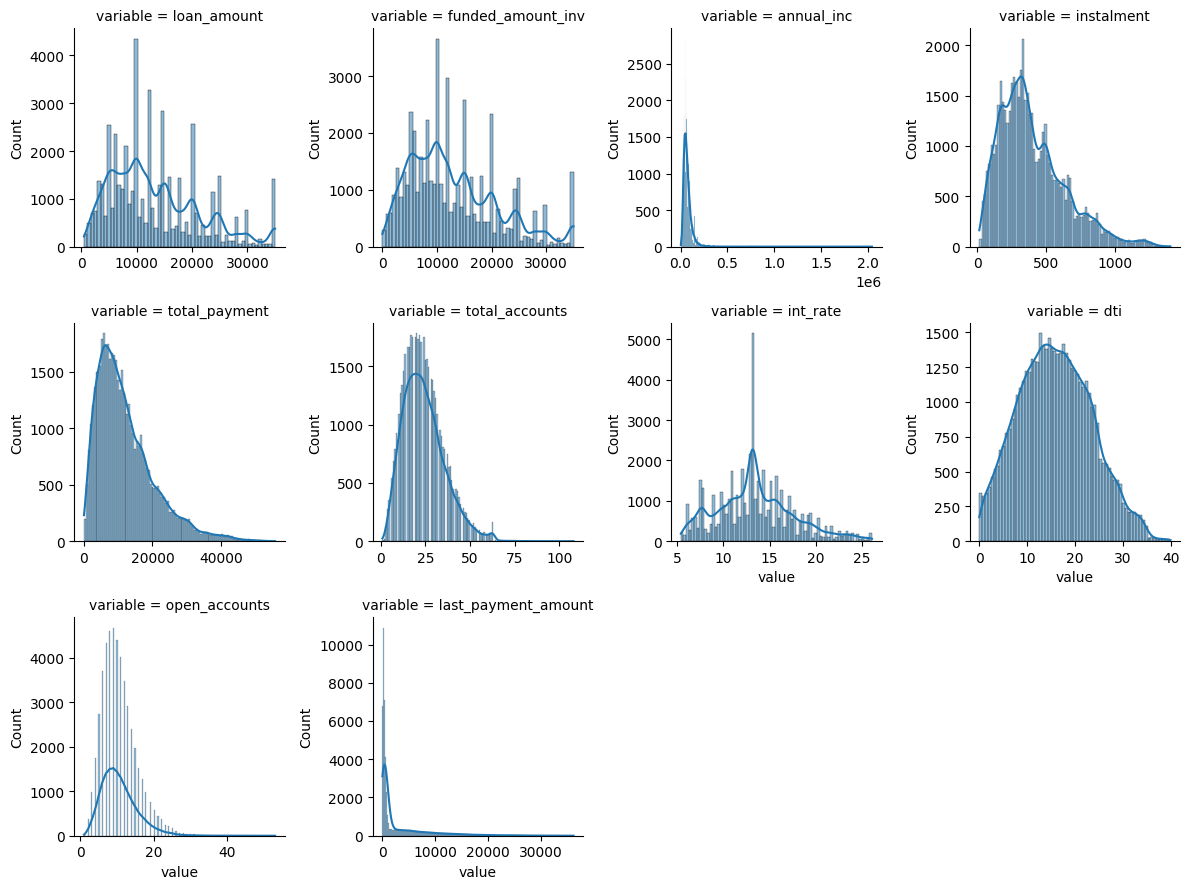

-------------------  --------
loan_amount          0.803086
funded_amount_inv    0.812809
annual_inc           8.5568
instalment           0.994334
total_payment        1.27219
total_accounts       0.774628
int_rate             0.454882
dti                  0.191426
open_accounts        1.05519
last_payment_amount  2.4895
-------------------  --------


In [6]:
#We will measure the skewness of the numerical columns 

numerical_cols = ['loan_amount','funded_amount_inv', 'annual_inc', 'instalment','total_payment', 'total_accounts', 'int_rate',  'dti', 'open_accounts', 'last_payment_amount']

plt.multiple_histogram_plot(numerical_cols)
DF_Info.data_skew(numerical_cols)

qq plot

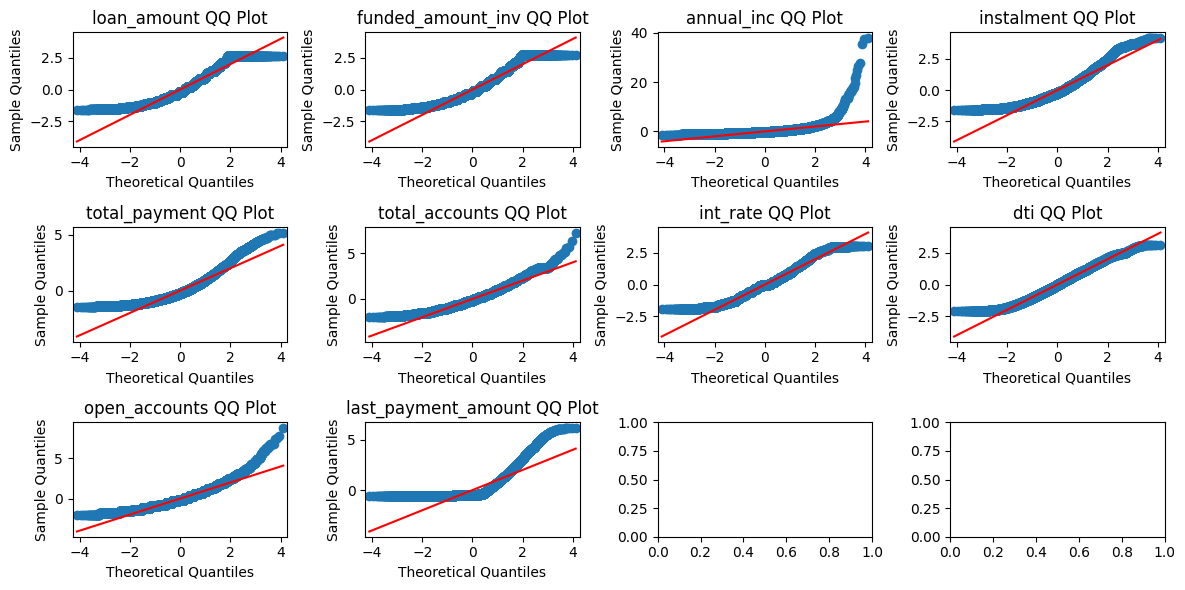

In [7]:
plt.multiple_qq_plot(numerical_cols)
Df_Info = DataFrameInfo(Transform_Formatted_data.df)
RDSDatabaseConnector.save_data_to_csv(Transform_Formatted_data.df, 'Transformed_and_Formatted_loan_data.csv')

Apply box cox and log transformation to columns to reduce skew

-------------------  ----------
loan_amount          -0.0435796
funded_amount_inv    -0.0535025
annual_inc            0.141846
instalment           -0.021036
total_payment        -0.0137722
total_accounts       -0.687909
int_rate             -0.0135304
dti                  -0.12456
open_accounts        -0.471295
last_payment_amount   0.133147
-------------------  ----------


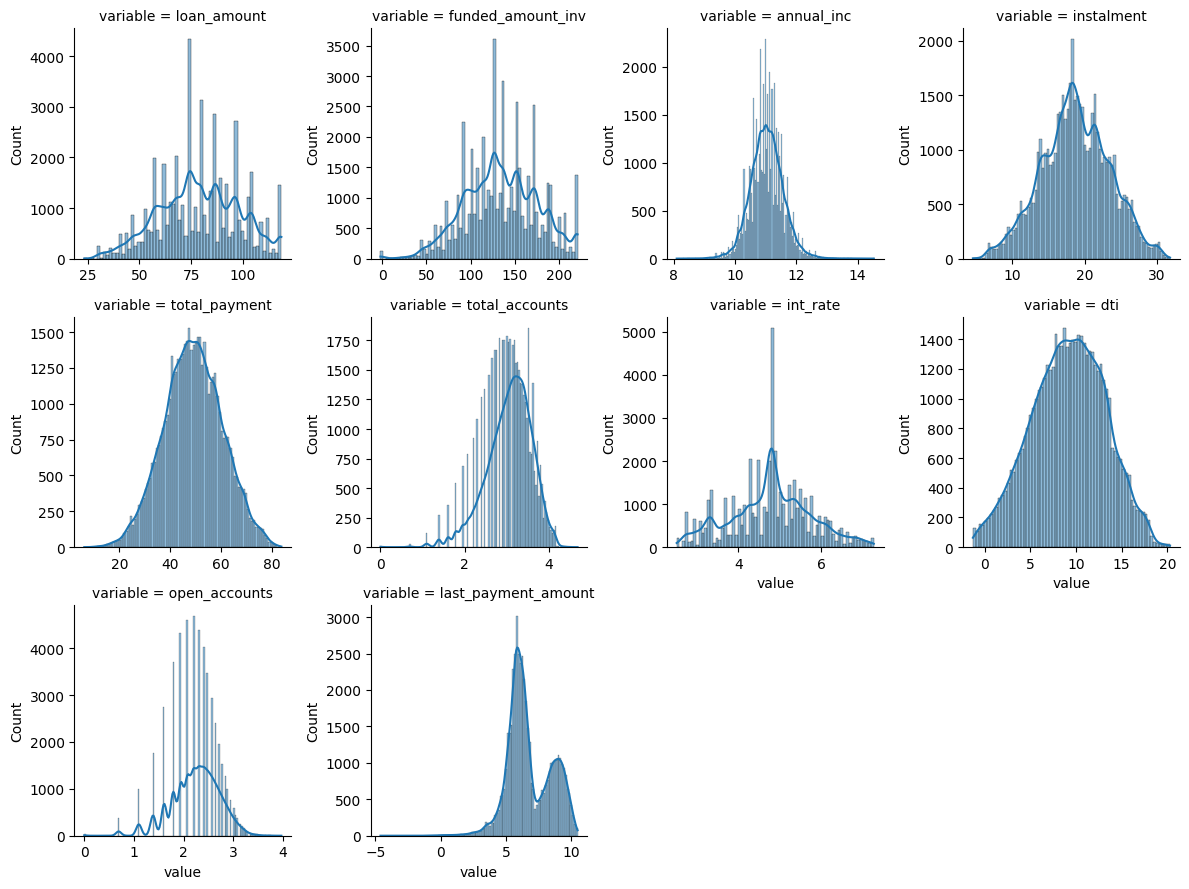

In [8]:

Box_cox_transfrom_columns=  ['loan_amount', 'instalment', 'int_rate', 'dti','funded_amount_inv', 'total_payment']
Log_transform_columns = ['annual_inc', 'total_accounts',
                      'open_accounts', 'last_payment_amount']

Transform_Formatted_data.box_cox_transform(Box_cox_transfrom_columns)
Transform_Formatted_data.log_transform(Log_transform_columns)

Df_Info.data_skew(numerical_cols)

#The Skew values are much lower after the transformations
plt.multiple_histogram_plot(numerical_cols)


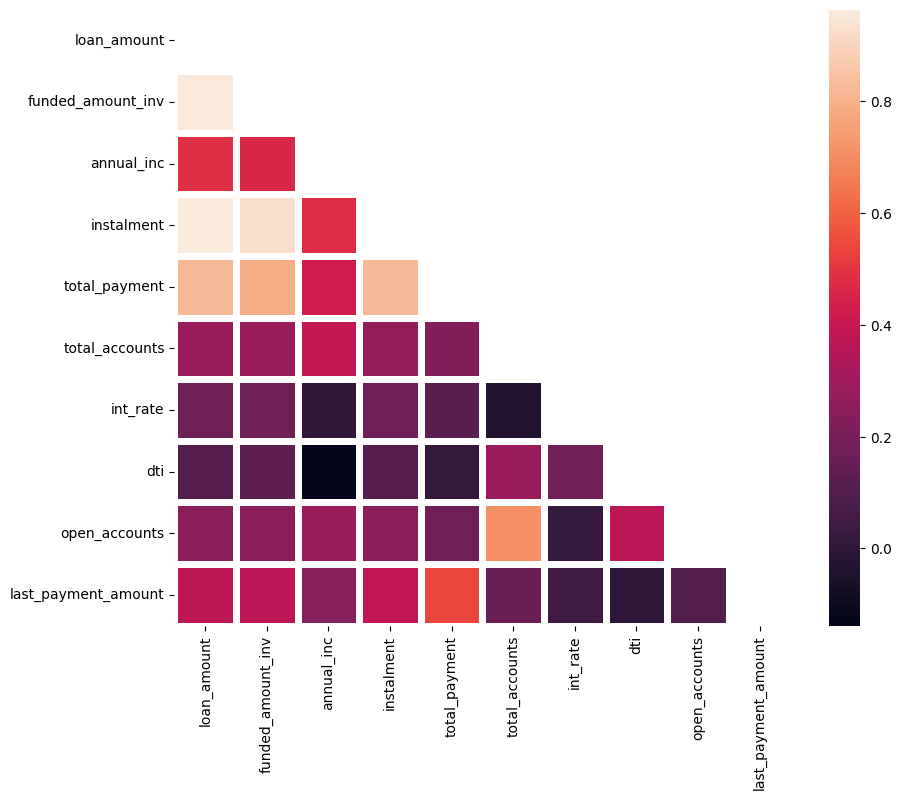

In [9]:

plt.correlated_variables(numerical_cols)


RDSDatabaseConnector.save_data_to_csv(Transform_Formatted_data.df, 'Final_loan_data.csv')